In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

from env import Env
from model_dqn import QNet
from utils import generate_actions

In [2]:
action_list = generate_actions()

env = Env()

model = QNet(n_actions=len(action_list), n_observations=6)
model.load_state_dict(torch.load("../results-train/Q_model_FINAL_cpu.dump"))
model.eval()

QNet(
  (fc1): Linear(in_features=6, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=21, bias=True)
  (act): ReLU()
)

In [3]:
env.total_ru_services

[[4, 1, 0],
 [3, 1, 1],
 [2, 1, 2],
 [0, 1, 4],
 [1, 1, 3],
 [0, 0, 5],
 [2, 2, 1],
 [3, 2, 0]]

In [4]:
env.reset()
state = env.get_state()

actions = []
bands = []
energy = []
for time in range(8):
    bands.append(state[:3])
    energy.append(env.energy_consumption)
    with torch.no_grad():
        X = torch.tensor(state).unsqueeze(0).to(torch.float)
        action_q_values = model(X).numpy().squeeze()

    action = int(np.argmax(action_q_values, axis=0))
    next_state, reward = env.processing(time, action_list[action])

    state = next_state

    if reward < 0:
        break

    actions.append(action_list[action])

bands.append(env.get_state(7)[:3])
energy.append(env.energy_consumption)

In [5]:
print(actions)
print(bands)
print(energy)
print(env.total_ru_services)

[[5, 0, 0], [4, 0, 1], [2, 1, 2], [0, 0, 5], [1, 0, 4], [0, 0, 5], [4, 0, 1], [2, 3, 0]]
[[0, 0, 0], [9830, 0, 0], [17768, 1892, 0], [22522.4, 6967.6, 0], [22892.4, 16427.6, 0], [25154.4, 18319.6, 5676], [25524.4, 18319.6, 15136], [33462.4, 18319.6, 17028], [39417.600000000006, 19611.199999999997, 19611.199999999997]]
[0, 600, 900, 900, 900, 1200, 1200, 1200, 1200]
[[4, 1, 0], [3, 1, 1], [2, 1, 2], [0, 1, 4], [1, 1, 3], [0, 0, 5], [2, 2, 1], [3, 2, 0]]


In [6]:
############ PARTES DAS MÉTRICAS ###########3

###############################################
# Convertendo para arrays numpy
bands_array = np.array(bands)
action_array = np.array(actions)
cloud_band = bands_array[:, 0]
fogs_sum = np.sum(bands_array[:, 1:], axis=1)
time_steps = np.arange(len(bands_array))
###############################################

# Calculando a quantidade de VPONs para cada tempo
vpon_counts = np.ceil(cloud_band / 10000) + np.ceil(fogs_sum / 10000)

# Capacidade de cada VPON
vpon_capacity = 10000

# Total de banda gerado em cada passo de tempo
total_ru_bands = np.sum(bands_array, axis=1)

# Eficiência da ativação das VPONs em porcentagem
efficiency_percentage = np.array(
    [total_ru_bands[i] / (vpon_counts[i] * 10000) * 100 if vpon_counts[i] > 0 else 0 for i in range(len(bands))]
)

# Disponibilidade do sistema
availability_percentage = np.array(
    [
        ((vpon_counts[i] * 10000) / total_ru_bands[i]) * 100 if total_ru_bands[i] > (vpon_counts[i] * 10000) else 100
        for i in range(len(bands))
    ]
)

print(efficiency_percentage)
print(availability_percentage)

[ 0.         98.3        65.53333333 73.725      78.64       81.91666667
 84.25714286 86.0125     98.3       ]
[100 100 100 100 100 100 100 100 100]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


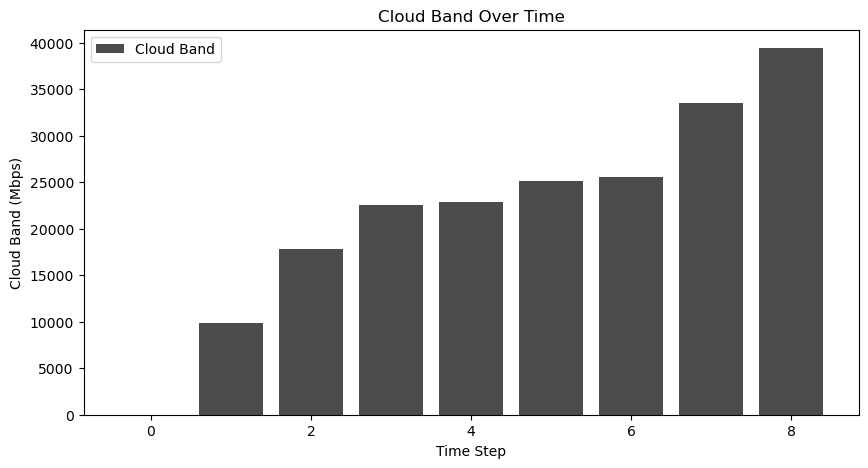

In [7]:
# banda cloud
plt.figure(figsize=(10, 5))
plt.bar(time_steps, cloud_band, label="Cloud Band", color="black", alpha=0.7)
plt.xlabel("Time Step")
plt.ylabel("Cloud Band (Mbps)")
plt.title("Cloud Band Over Time")
plt.legend()
plt.savefig("cloud_bands.eps", dpi=400)
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


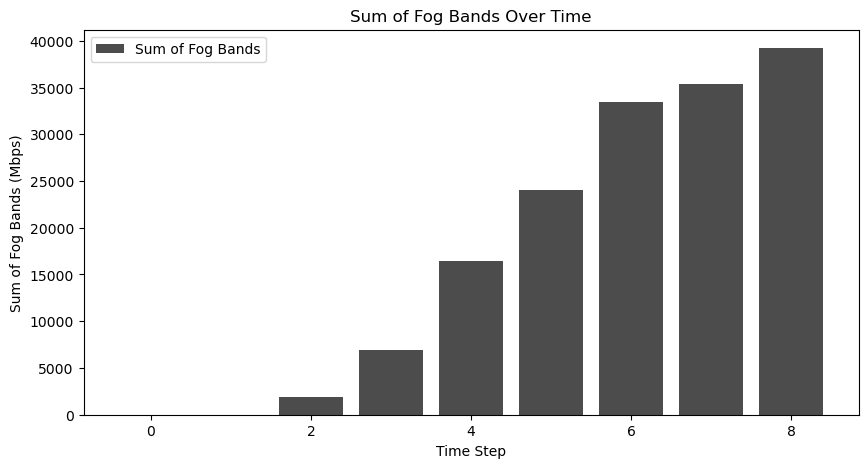

In [8]:
# soma das bandas fogs
plt.figure(figsize=(10, 5))
plt.bar(time_steps, fogs_sum, label="Sum of Fog Bands", color="black", alpha=0.7)
plt.xlabel("Time Step")
plt.ylabel("Sum of Fog Bands (Mbps)")
plt.title("Sum of Fog Bands Over Time")
plt.legend()
plt.savefig("fog_bands.eps", dpi=400)
plt.show()

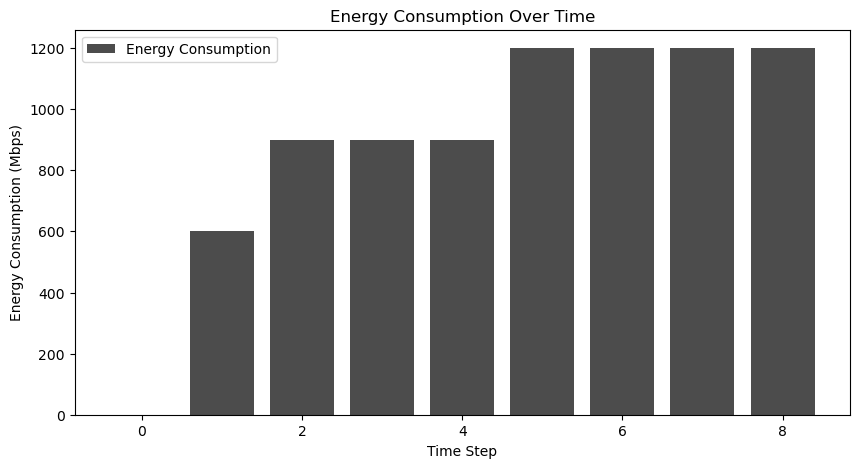

In [9]:
# energia sem as vpons
plt.figure(figsize=(10, 5))
plt.bar(time_steps, energy, label="Energy Consumption", color="black", alpha=0.7)
plt.xlabel("Time Step")
plt.ylabel("Energy Consumption (Mbps)")
plt.title("Energy Consumption Over Time")
plt.legend()
plt.show()

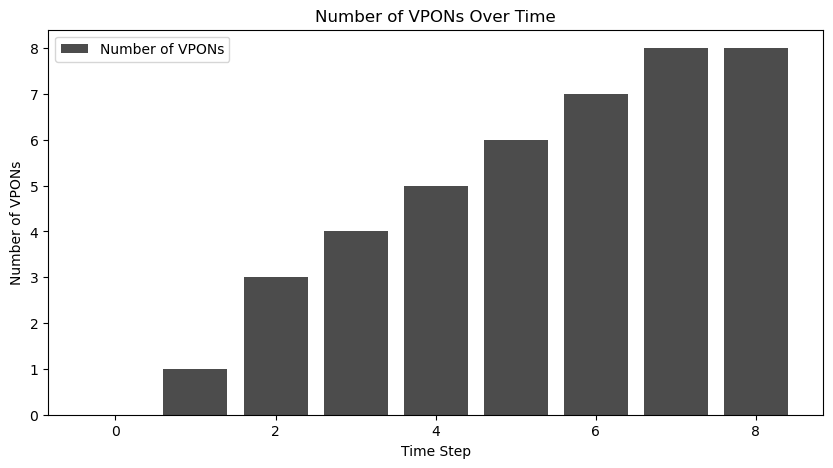

In [10]:
# quantidade de VPONs Ativas
plt.figure(figsize=(10, 5))
plt.bar(time_steps, vpon_counts, label="Number of VPONs", color="black", alpha=0.7)
plt.xlabel("Time Step")
plt.ylabel("Number of VPONs")
plt.title("Number of VPONs Over Time")
plt.legend()
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


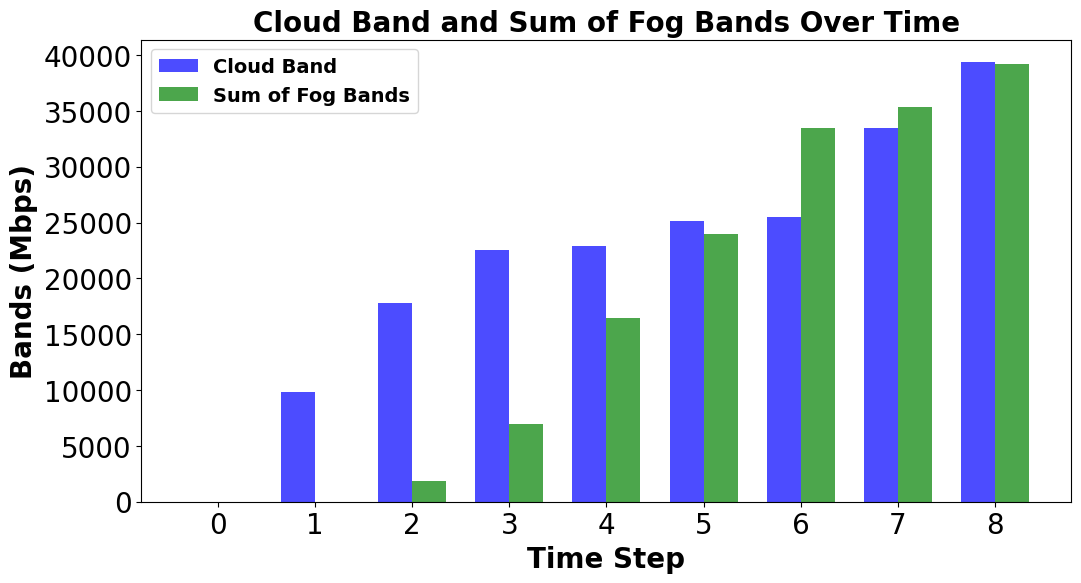

In [63]:
# tráfeogo total = banda da cloud com a soma das bandas das fogs
bar_width = 0.35
r1 = np.arange(len(time_steps))
r2 = [x + bar_width for x in r1]

plt.figure(figsize=(12, 6))
plt.bar(r1, cloud_band, width=bar_width, label="Cloud Band", color="blue", alpha=0.7)
plt.bar(r2, fogs_sum, width=bar_width, label="Sum of Fog Bands", color="green", alpha=0.7)

plt.xlabel("Time Step", fontweight="bold", fontsize=20)
plt.ylabel("Bands (Mbps)", fontweight="bold", fontsize=20)
plt.title("Cloud Band and Sum of Fog Bands Over Time", fontweight="bold", fontsize=20)
plt.xticks([r + bar_width / 2 for r in range(len(time_steps))], time_steps, fontsize=20)
plt.yticks(fontsize=20)
plt.legend(prop={'weight':'bold', 'size':14})
plt.savefig("cloud_fog_band_over_time.eps", dpi=400)
plt.show()

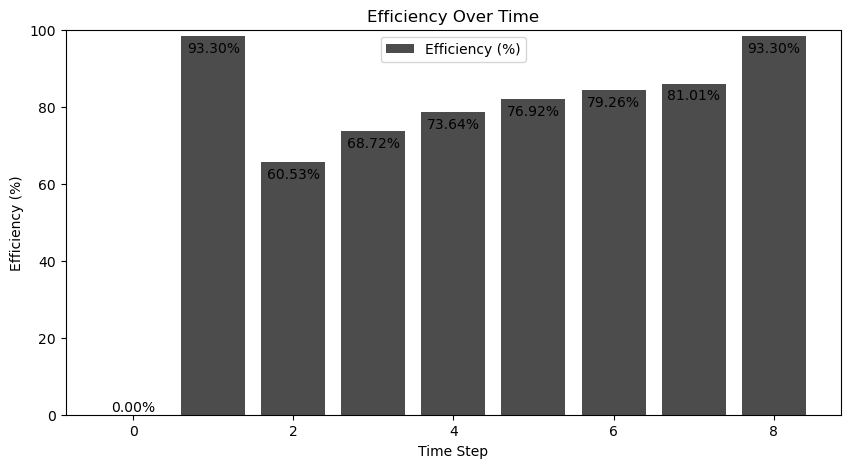

In [12]:
# eficiência da ativação das VPONs/ vpons por tráfego gerado
plt.figure(figsize=(10, 5))
bars = plt.bar(time_steps, efficiency_percentage, label="Efficiency (%)", color="black", alpha=0.7)

plt.xlabel("Time Step")
plt.ylabel("Efficiency (%)")
plt.title("Efficiency Over Time")
plt.ylim(0, 100)  # Definindo o limite do eixo y de 0 a 100%
plt.legend()

# Adicionando os valores das barras
for bar in bars:
    yval = bar.get_height()
    if yval != 0:
        yval = yval - 5
    plt.text(bar.get_x() + bar.get_width() / 2.0, yval, f"{yval:.2f}%", va="bottom", ha="center")

plt.show()

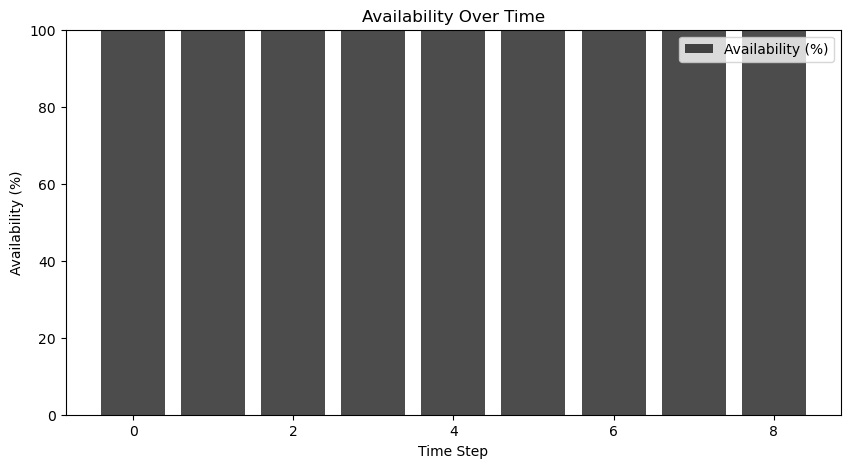

In [13]:
# disponibilidade em porcentagem
plt.figure(figsize=(10, 5))
plt.bar(time_steps, availability_percentage, label="Availability (%)", color="black", alpha=0.7)
plt.xlabel("Time Step")
plt.ylabel("Availability (%)")
plt.title("Availability Over Time")
plt.ylim(0, 100)  # Definindo o limite do eixo y de 0 a 100%
plt.legend()
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


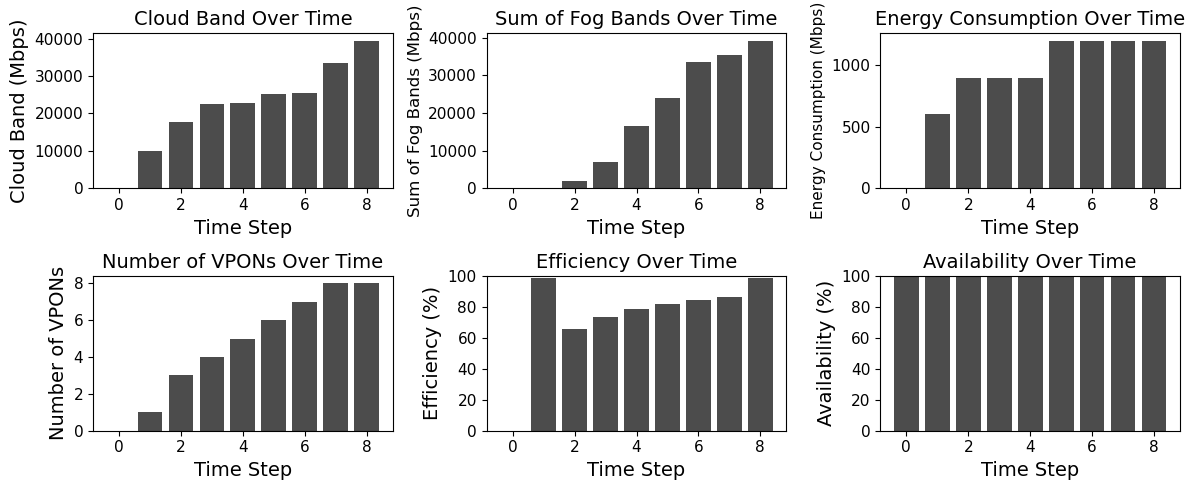

In [59]:
# Criando o quadro com subfiguras
fig, axs = plt.subplots(2, 3, figsize=(12, 5), tight_layout=True)
plt.subplots_adjust(hspace=0.4, wspace=0.3)
# 1ª Subfigura: Banda Cloud
axs[0, 0].bar(time_steps, cloud_band, color="black", alpha=0.7)
axs[0, 0].set_xlabel("Time Step", fontsize=14)
axs[0, 0].set_ylabel("Cloud Band (Mbps)", fontsize=14)
axs[0, 0].set_title("Cloud Band Over Time", fontsize=14)
axs[0, 0].tick_params(axis="both", labelsize=11) 
# axs[0, 0].legend()

# 2ª Subfigura: Soma das Bandas Fog
axs[0, 1].bar(time_steps, fogs_sum, color="black", alpha=0.7)
axs[0, 1].set_xlabel("Time Step", fontsize=14)
axs[0, 1].set_ylabel("Sum of Fog Bands (Mbps)", fontsize=12)
axs[0, 1].set_title("Sum of Fog Bands Over Time", fontsize=14)
axs[0, 1].tick_params(axis="both", labelsize=11) 
# axs[0, 1].legend()

# 3ª Subfigura: Energia sem as VPONsu
axs[0, 2].bar(time_steps, energy, color="black", alpha=0.7)
axs[0, 2].set_xlabel("Time Step", fontsize=14)
axs[0, 2].set_ylabel("Energy Consumption (Mbps)", fontsize=11)
axs[0, 2].set_title("Energy Consumption Over Time", fontsize=14)
axs[0, 2].tick_params(axis="both", labelsize=11) 
# axs[0, 2].legend()

# 4ª Subfigura: Quantidade de VPONs Ativas
axs[1, 0].bar(time_steps, vpon_counts, color="black", alpha=0.7)
axs[1, 0].set_xlabel("Time Step", fontsize=14)
axs[1, 0].set_ylabel("Number of VPONs", fontsize=14)
axs[1, 0].set_title("Number of VPONs Over Time", fontsize=14)
axs[1, 0].tick_params(axis="both", labelsize=11) 
# axs[1, 0].legend()

# 5ª Subfigura: Eficiência da Ativação das VPONs
bars = axs[1, 1].bar(time_steps, efficiency_percentage, color="black", alpha=0.7)
axs[1, 1].set_xlabel("Time Step", fontsize=14)
axs[1, 1].set_ylabel("Efficiency (%)", fontsize=14)
axs[1, 1].set_title("Efficiency Over Time", fontsize=14)
axs[1, 1].set_ylim(0, 100)  # Definindo o limite do eixo y de 0 a 100%
axs[1, 1].tick_params(axis="both", labelsize=11) 
# axs[1, 1].legend()

# 6ª Subfigura: Disponibilidade em Porcentagem
axs[1, 2].bar(time_steps, availability_percentage, color="black", alpha=0.7)
axs[1, 2].set_xlabel("Time Step", fontsize=14)
axs[1, 2].set_ylabel("Availability (%)", fontsize=14)
axs[1, 2].set_title("Availability Over Time", fontsize=14)
axs[1, 2].set_ylim(0, 100)  # Definindo o limite do eixo y de 0 a 100%
axs[1, 2].tick_params(axis="both", labelsize=11) 
# axs[1, 2].legend()

# Ajustando o layout para evitar sobreposição
plt.tight_layout()

# Salvando a figura em EPS com 400 DPI
plt.savefig("composite_figure.eps", dpi=400, bbox_inches="tight")

# Mostrando a figura
plt.show()

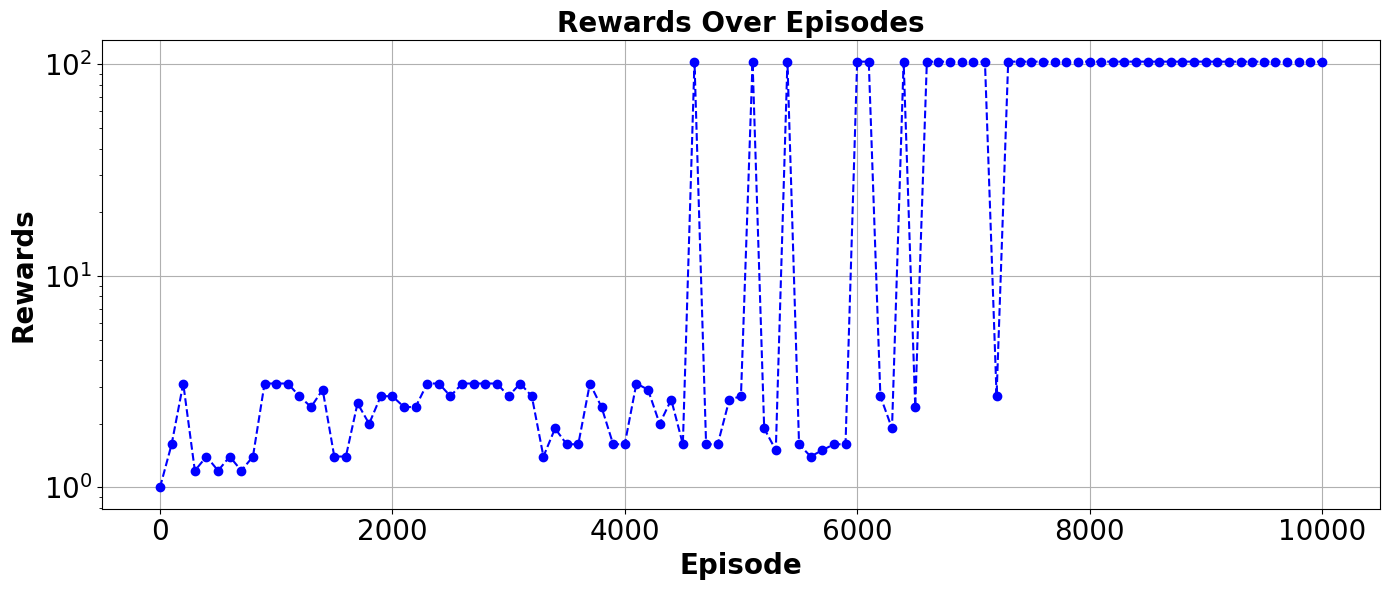

In [15]:
# Carregar dados do arquivo JSON
with open("../results-train/log.txt", "r") as f:
    a = f.readlines()
    rewards = [float(x.split("reward: ")[1].split(" state:")[0]) for x in a[1:]]

x = [rewards[i] for i in range(0, len(rewards), 100)]
y = range(0, 10001, 100)


# Plotar o gráfico
fig = plt.figure(figsize=(14, 6))
plt.plot(y, x, marker="o", linestyle="--", color="b")
plt.xlabel("Episode", fontweight="bold", fontsize=20)
plt.ylabel("Rewards", fontweight="bold", fontsize=20)
plt.yscale("log")
plt.title("Rewards Over Episodes", fontweight="bold", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.tight_layout()
plt.savefig("dqn.eps", dpi=400, bbox_inches="tight")
plt.show()